# Standardized GLM
1. Load the individual connectomes
2. Load the phenotype information
3. Compute the SD of the control group
4. Delete everyone by the SD of the control group

Centering by the mean of the control group is optional as that shouldn't affect the group contrast unless we are looking at DEL vs DUP.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import patsy as pat
import nibabel as nib
import pathlib as pal
import seaborn as sbn
from scipy import io as sio
from sklearn import linear_model as sln
from matplotlib import pyplot as plt

In [13]:
# Paths
root_p = pal.Path('/home/surchs/data/paper_16p22q/')
connectome_p = root_p / 'glm/16p/cambridge64/individual/'
connectome_t = 'connectome_{}_cambridge64.mat'
pheno_p = root_p / 'pheno/Pheno_16p.csv'
figure_p = root_p / 'figures/unclear/'

In [4]:
pheno = pd.read_csv(str(pheno_p))
pheno.rename(columns={'Unnamed: 0':'niak_id'}, inplace=True)
n_subjects = pheno.shape[0]

In [5]:
# Give me the connectomes
conn = np.array([sio.loadmat(str(connectome_p / connectome_t.format(row['niak_id'])))['mean_con']['connectome'][0][0].squeeze()
                 for rid, row in pheno.iterrows()])

Intercept, sex_dummy, FD_scrubbed_both_norm, Site_dummy

In [6]:
# Scale Y to unit SD of controls
control_mask = (pheno.genetic_status_16p==2).values
control_sd = np.std(conn[control_mask, :], 0)
conn_sd = conn / np.tile(control_sd, (n_subjects,1))

not_g1_mask = (pheno.genetic_status_16p!=1).values
not_g3_mask = (pheno.genetic_status_16p!=3).values

conn_del_minus_con = conn_sd[not_g3_mask]
conn_dup_minus_con = conn_sd[not_g1_mask]

In [7]:
# Build the design matrix for del_minus_con
dmat_del_minus_con = pat.dmatrix('sex_dummy + age_months_norm + FD_scrubbed_both_norm + Site_dummy + g1', pheno.loc[not_g3_mask])
# Build the GLM
glm = sln.LinearRegression(fit_intercept=False, normalize=False)
res = glm.fit(dmat_del_minus_con, conn_del_minus_con)
# Get the beta for genetic status
beta_del_minus_con = res.coef_[:, -1]

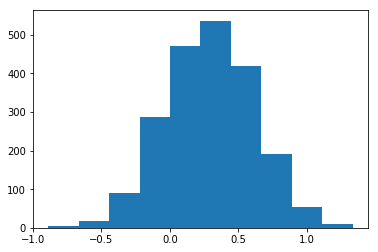

In [12]:
plt.hist(beta_del_minus_con);

In [9]:
# Build the design matrix for del_minus_con
dmat_dup_minus_con = pat.dmatrix('sex_dummy + age_months_norm + FD_scrubbed_both_norm + Site_dummy + g3', pheno.loc[not_g1_mask])
# Build the GLM
glm = sln.LinearRegression(fit_intercept=False, normalize=False)
res = glm.fit(dmat_dup_minus_con, conn_dup_minus_con)
# Get the beta for genetic status
beta_dup_minus_con = res.coef_[:, -1]

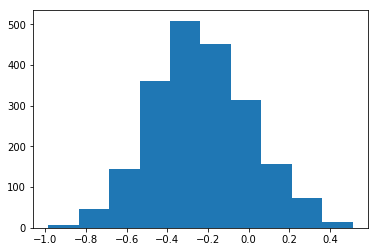

In [11]:
plt.hist(beta_dup_minus_con);

/home/surchs/conda/envs/svip/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


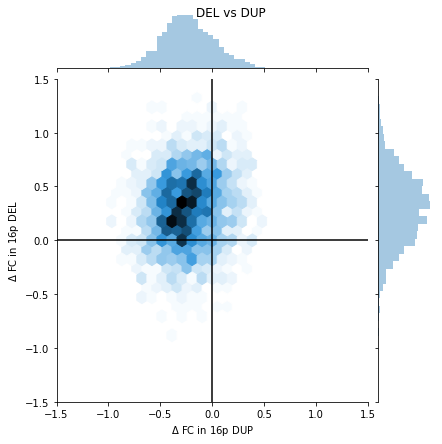

In [14]:
r = 1.5
g = sbn.jointplot(x=beta_dup_minus_con, y=beta_del_minus_con, kind='hex', ylim=(-r, r), xlim=(-r, r), joint_kws={"extent": (-r, r, -r, r)},
                 stat_func=None)
g.ax_joint.plot([0, 0], [-r, r], 'k')
g.ax_joint.plot([-r, r], [0, 0], 'k')
tmp = g.ax_joint.set(xlabel='$\Delta$ FC in 16p DUP', ylabel='$\Delta$ FC in 16p DEL')
g.fig.suptitle('DEL vs DUP');
g.savefig(str(figure_p / '16p_age_z_heatmap.png'), dpi=300, transparent=True);

In [15]:
# Save the standardized effects
np.save(str(root_p / 'glm/16p_age/16p_DEL_CON_age_standardized_effect.npy'), beta_del_minus_con)
np.save(str(root_p / 'glm/16p_age/16p_DUP_CON_age_standardized_effect.npy'), beta_dup_minus_con)